<a href="https://colab.research.google.com/github/Hamida24/Riset-Informatika/blob/main/Project_CNN_%2B_KNN_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library Yang Digunakan**

---

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay

from datetime import datetime
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Persiapan dan Load Dataset**

---

In [2]:
# Konfigurasi untuk load dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset'
img_height = 224
img_width = 224
batch_size = 32
epochs = 50
seed = 42

# Jumlah Kelas
class_names = ['Mentah', 'Setengah matang', 'Matang']
num_classes = len(class_names)

# Pengaturan seed
np.random.seed(seed)
tf.random.set_seed(seed)

print("="*80)
print("MEMUAT DATASET MELINJO")
print("="*80)
print(f"Data Directory: {data_dir}")
print(f"Image Size: {img_height}x{img_width}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Random Seed: {seed}")
print("="*80)

MEMUAT DATASET MELINJO
Data Directory: /content/drive/MyDrive/Colab Notebooks/Dataset
Image Size: 224x224
Batch Size: 32
Epochs: 50
Random Seed: 42


Loading Dataset...
Loading Mentah... 270 images loaded
Loading Setengah matang... 253 images loaded
Loading Matang... 288 images loaded


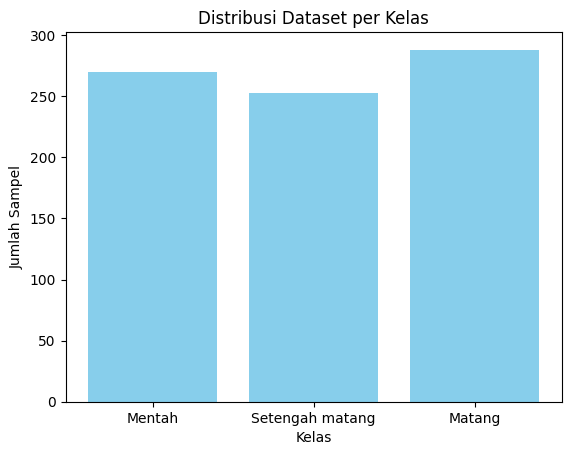

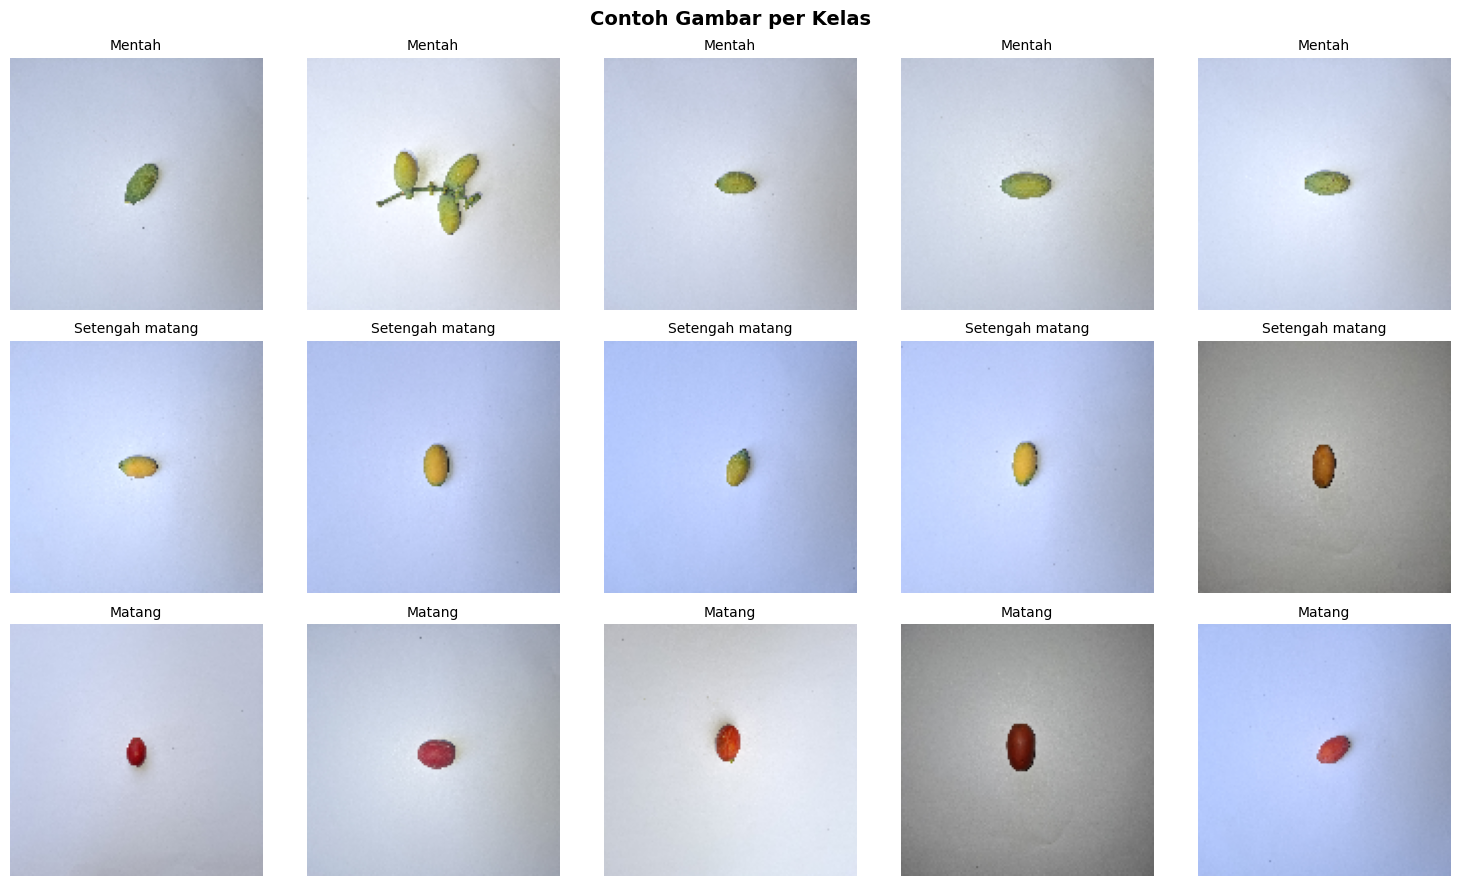

Load dan visualisasi dataset selesai dilakukan


In [3]:
# Load dataset
def load_dataset(data_dir, class_names, image_size=(224, 224)):
    print("Loading Dataset...")
    images, labels = [], []

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        count = 0  # hitung jumlah gambar per kelas

        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(class_path, file)
                img = tf.keras.utils.load_img(img_path, target_size=image_size)
                img = tf.keras.utils.img_to_array(img)
                images.append(img)
                labels.append(label)
                count += 1

        # tampilkan jumlah dataset per kelas
        print(f"Loading {class_name}... {count} images loaded")
        print("="*60)

    return np.array(images), np.array(labels)

# Visualisasi distribusi kelas
def plot_class_distribution(y, class_names):
    counts = Counter(y)
    plt.bar(class_names, [counts[i] for i in range(len(class_names))], color='skyblue')
    plt.title("Distribusi Dataset per Kelas")
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Sampel")
    plt.show()

# Visualisasi sampel per kelas
def plot_sample_images(X, y, class_names, samples_per_class=3):
    n_classes = len(class_names)
    plt.figure(figsize=(samples_per_class * 3, n_classes * 3))

    for class_idx, class_name in enumerate(class_names):
        indices = np.where(y == class_idx)[0]
        sample_indices = np.random.choice(indices, min(samples_per_class, len(indices)), replace=False)

        for i, idx in enumerate(sample_indices):
            plt.subplot(n_classes, samples_per_class, class_idx * samples_per_class + i + 1)
            plt.imshow(X[idx].astype('uint8'))
            plt.axis('off')
            plt.title(class_name, fontsize=10)  # nama kelas di bawah gambar

    plt.suptitle("Contoh Gambar per Kelas", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Memanggil fungsi yang telah dituliskan diatas
X, y = load_dataset(data_dir, class_names, image_size=(128, 128))
plot_class_distribution(y, class_names)
plot_sample_images(X, y, class_names, samples_per_class=5)
print("Load dan visualisasi dataset selesai dilakukan")

# **Split Dataset**

In [4]:
def split_data(X, y, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2,
               random_state=42, verbose=True):

    if verbose:
        print("="*60)
        print("DATA SPLITTING (Stratified)")
        print("="*60)

    # Split 1: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=(val_ratio + test_ratio),
        random_state=random_state,
        stratify=y
    )

    # Split 2: val vs test
    relative_test_size = test_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=relative_test_size,
        random_state=random_state,
        stratify=y_temp
    )

    if verbose:
        print(f"\nSplit Ratios: Train={train_ratio:.0%}, Val={val_ratio:.0%}, Test={test_ratio:.0%}")
        print(f"\nDataset Sizes:")
        print(f"  Training   : {len(X_train):4d} ({len(X_train)/len(X)*100:5.1f}%)")
        print(f"  Validation : {len(X_val):4d} ({len(X_val)/len(X)*100:5.1f}%)")
        print(f"  Test       : {len(X_test):4d} ({len(X_test)/len(X)*100:5.1f}%)")

        print(f"\nDistribution per Split:")
        for split_name, split_y in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
            print(f"  {split_name:10}", end='')
            for i, class_name in enumerate(class_names):
                count = np.sum(split_y == i)
                print(f" | {class_name[:10]:10} : {count:3d}", end='')
            print()

        print("="*60 + "\n")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, random_state=seed)

DATA SPLITTING (Stratified)

Split Ratios: Train=60%, Val=20%, Test=20%

Dataset Sizes:
  Training   :  486 ( 59.9%)
  Validation :  162 ( 20.0%)
  Test       :  163 ( 20.1%)

Distribution per Split:
  Train      | Mentah     : 162 | Setengah m : 152 | Matang     : 172
  Val        | Mentah     :  54 | Setengah m :  50 | Matang     :  58
  Test       | Mentah     :  54 | Setengah m :  51 | Matang     :  58



# **Preprocessing dan augmentasi data**



In [5]:
# Fungsi proses resize
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_height, img_width], method='bicubic')
    image = image / 255.0
    return image, label

In [6]:
# Proses augmentasi data
data_augmentasi = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(factor=0.10),
    layers.RandomBrightness(factor=0.10, value_range=(0.0, 1.0)),
])

In [8]:
# Training dengan augmentasi
def create_dataset(X, y, batch_size=32, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.shuffle(len(X))
        ds = ds.map(
            lambda x, y:(data_augmentasi(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(X_train, y_train, batch_size, training=True)
val_ds   = create_dataset(X_val, y_val, batch_size, training=False)
test_ds  = create_dataset(X_test, y_test, batch_size, training=False)

print("Dataset siap digunakan")

Dataset siap digunakan


# **Fungsi Evaluasi dan Visualisasi**

In [9]:
print("="*80)
print("CELL 3: HELPER FUNCTIONS")
print("="*80)

ALL_RESULTS = {}

# Evaluasi dan menyimpan hasil
def evaluate_and_save(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    results = {
        'name': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'predictions': y_pred
    }

    ALL_RESULTS[name] = results

    print(f"\n{name}")
    print(f"  Accuracy: {acc:.4f} | F1: {f1:.4f}")

    return results

def complete_knn_pipeline(train_features, val_features, test_features,
                          y_train, y_val, y_test,
                          n_components=50, k_range=(3, 15),
                          model_name="KNN_Pipeline"):

    print(f"\n{'='*70}")
    print(f"COMPLETE KNN PIPELINE: {model_name}")
    print(f"{'='*70}")

    # ===== STEP 1: PCA =====
    print(f"\n[STEP 1/4] PCA (n_components={n_components})")
    pca = PCA(n_components=n_components, random_state=42)
    train_pca = pca.fit_transform(train_features)
    val_pca = pca.transform(val_features)
    test_pca = pca.transform(test_features)

    explained_var = pca.explained_variance_ratio_.sum()
    print(f"  ✓ Original: {train_features.shape[1]} features")
    print(f"  ✓ Reduced to: {train_pca.shape[1]} components")
    print(f"  ✓ Explained variance: {explained_var:.4f}")

    # ===== STEP 2: STANDARDIZATION =====
    print(f"\n[STEP 2/4] Standardization (StandardScaler)")
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_pca)
    val_scaled = scaler.transform(val_pca)
    test_scaled = scaler.transform(test_pca)
    print(f"  ✓ Mean: {train_scaled.mean():.4f}, Std: {train_scaled.std():.4f}")

    # ===== STEP 3: GRIDSEARCH =====
    print(f"\n[STEP 3/4] GridSearchCV (K={k_range[0]}-{k_range[1]})")
    param_grid = {
        'n_neighbors': list(range(k_range[0], k_range[1] + 1)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid.fit(train_scaled, y_train)

    print(f"  ✓ Best K: {grid.best_params_['n_neighbors']}")
    print(f"  ✓ Best weights: {grid.best_params_['weights']}")
    print(f"  ✓ Best metric: {grid.best_params_['metric']}")
    print(f"  ✓ Best CV score: {grid.best_score_:.4f}")

    # ===== STEP 4: EVALUATION =====
    print(f"\n[STEP 4/4] Evaluation")

    # Validation set
    val_pred = grid.predict(val_scaled)
    val_acc = accuracy_score(y_val, val_pred)

    # Test set
    test_pred = grid.predict(test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average='weighted'
    )

    print(f"  ✓ Validation Accuracy: {val_acc:.4f}")
    print(f"  ✓ Test Accuracy: {test_acc:.4f}")
    print(f"  ✓ Test F1-Score: {test_f1:.4f}")

    results = {
        'model_name': model_name,
        'pca_components': n_components,
        'pca_variance': explained_var,
        'best_k': grid.best_params_['n_neighbors'],
        'best_params': grid.best_params_,
        'cv_score': grid.best_score_,
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1,
        'predictions': test_pred,
        'confusion_matrix': confusion_matrix(y_test, test_pred),
        'grid_search': grid,
        'pca': pca,
        'scaler': scaler
    }

    print(f"{'='*70}\n")

    return results

print("✓ Helper functions defined!")
print("="*80 + "\n")


CELL 3: HELPER FUNCTIONS
✓ Helper functions defined!



# **Fungsi Hybrid Pooling Layer**

In [10]:
# Fungsi hybrid pooling layer
class HybridPooling(layers.Layer):
    def __init__(self, pool_size=(2,  2), alpha=0.5, **kwargs):
        super(HybridPooling, self).__init__(**kwargs)
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f"alpha must be in [0, 1], dapat {alpha}")

        self.alpha = float(alpha)
        self.pool_size = pool_size

        # Spatial pooling
        self.max_pool = layers.MaxPooling2D(pool_size)
        self.avg_pool = layers.AveragePooling2D(pool_size)

    def call(self, inputs):
        # Hitung average dan max pooling
        max_output = self.max_pool(inputs)
        avg_output = self.avg_pool(inputs)
        return self.alpha * max_output + (1 - self.alpha) * avg_output

    def get_config(self):
        config = super().get_config()
        config.update({
            'pool_size': self.pool_size,
            'alpha' : self.alpha
        })
        return config

print("Hybrid Pooling Layer defined successfully!")

Hybrid Pooling Layer defined successfully!


# **Skenario 1 - Model CNN With Maxpooling**

Model: "CNN_Standard_Maxpooling"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,387 (98.36 MB)

 Trainable params: 25,784,387 (98.36 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Training CNN Standard...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.3369 - loss: 4.1020
Epoch 1: val_accuracy improved from -inf to 0.35802, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 958ms/step - accuracy: 0.3371 - loss: 4.0190 - val_accuracy: 0.3580 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.3527 - loss: 1.1000
Epoch 2: val_accuracy did not improve from 0.35802
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.3536 - loss: 1.0999 - val_accuracy: 0.3333 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.3089 - loss: 1.0958
Epoch 3: val_accuracy did not improve from 0.35802
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step - accuracy: 0.3099 - loss: 1.0959 - val_accuracy: 0.3457 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.3725 - loss: 1.0906
Epoch 4: val_accuracy improved from 0.35802 to 0.41358, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - accuracy: 0.3737 - loss: 1.0901 - val_accuracy: 0.4136 - val_loss: 1.0583 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.4015 - loss: 1.0589
Epoch 5: val_accuracy improved from 0.41358 to 0.54938, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.4019 - loss: 1.0571 - val_accuracy: 0.5494 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.6642 - loss: 0.7902
Epoch 6: val_accuracy did not improve from 0.54938
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.6677 - loss: 0.7834 - val_accuracy: 0.4568 - val_loss: 1.2199 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7842 - loss: 0.5713
Epoch 7: val_accuracy improved from 0.54938 to 0.64198, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - accuracy: 0.7854 - loss: 0.5707 - val_accuracy: 0.6420 - val_loss: 0.8768 - learning_rate: 0.0010
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8145 - loss: 0.4712
Epoch 8: val_accuracy improved from 0.64198 to 0.65432, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 537ms/step - accuracy: 0.8123 - loss: 0.4742 - val_accuracy: 0.6543 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8044 - loss: 0.4224
Epoch 9: val_accuracy improved from 0.65432 to 0.93827, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.8050 - loss: 0.4222 - val_accuracy: 0.9383 - val_loss: 0.3202 - learning_rate: 0.0010
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8655 - loss: 0.3927
Epoch 10: val_accuracy did not improve from 0.93827
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - accuracy: 0.8656 - loss: 0.3921 - val_accuracy: 0.9136 - val_loss: 0.3194 - learning_rate: 0.0010
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8434 - loss: 0.4109
Epoch 11: val_accuracy did not improve from 0.93827
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.8415 - loss: 0.4137 - val_accuracy: 0.9321 - val_loss: 0.3104 - learning_rate: 0.0010
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8064 - loss: 0.4445
Epoch 12: val_accuracy did not improve from 0.93827
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 484ms/step - accuracy: 0.8057 - loss: 0.4448 - val_accuracy: 0.8765 - val_loss: 0.3954 - learning_rate: 0.0010
Epoch 13/50
16/16 ━

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.8835 - loss: 0.3187 - val_accuracy: 0.9506 - val_loss: 0.1945 - learning_rate: 0.0010
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8856 - loss: 0.2988
Epoch 15: val_accuracy did not improve from 0.95062
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 484ms/step - accuracy: 0.8838 - loss: 0.3033 - val_accuracy: 0.9259 - val_loss: 0.2883 - learning_rate: 0.0010
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8789 - loss: 0.3204
Epoch 16: val_accuracy did not improve from 0.95062
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - accuracy: 0.8789 - loss: 0.3216 - val_accuracy: 0.9506 - val_loss: 0.2300 - learning_rate: 0.0010
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8774 - loss: 0.3158
Epoch 17: val_accuracy did not improve from 0.95062
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.8781 - loss: 0.3155 - val_accuracy: 0.9383 - val_loss: 0.2197 - learning_rate: 0.0010
Epoch 18/50
16/16 

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 514ms/step - accuracy: 0.9170 - loss: 0.2847 - val_accuracy: 0.9568 - val_loss: 0.1856 - learning_rate: 0.0010
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9087 - loss: 0.2571
Epoch 20: val_accuracy improved from 0.95679 to 0.98148, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.9082 - loss: 0.2570 - val_accuracy: 0.9815 - val_loss: 0.1344 - learning_rate: 0.0010
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9103 - loss: 0.2135
Epoch 21: val_accuracy did not improve from 0.98148
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 470ms/step - accuracy: 0.9113 - loss: 0.2116 - val_accuracy: 0.9630 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9335 - loss: 0.1954
Epoch 22: val_accuracy improved from 0.98148 to 0.99383, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 588ms/step - accuracy: 0.9344 - loss: 0.1933 - val_accuracy: 0.9938 - val_loss: 0.0416 - learning_rate: 0.0010
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9580 - loss: 0.1361
Epoch 23: val_accuracy improved from 0.99383 to 1.00000, saving model to best_model_1.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 628ms/step - accuracy: 0.9584 - loss: 0.1350 - val_accuracy: 1.0000 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9716 - loss: 0.0953
Epoch 24: val_accuracy did not improve from 1.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.9709 - loss: 0.0967 - val_accuracy: 0.9691 - val_loss: 0.1008 - learning_rate: 0.0010
Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9683 - loss: 0.1158
Epoch 25: val_accuracy did not improve from 1.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.9687 - loss: 0.1146 - val_accuracy: 0.9938 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9694 - loss: 0.1119
Epoch 26: val_accuracy did not improve from 1.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - accuracy: 0.9693 - loss: 0.1106 - val_accuracy: 0.9938 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 27/50
16/16 

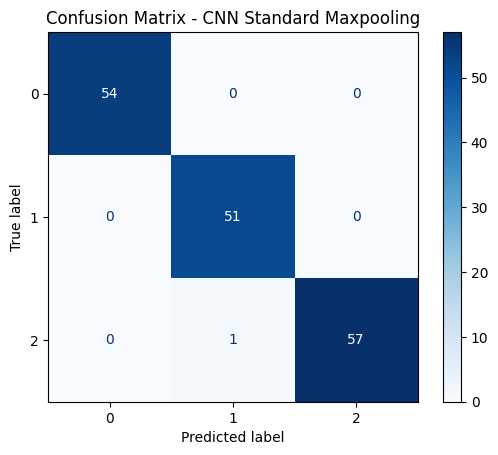

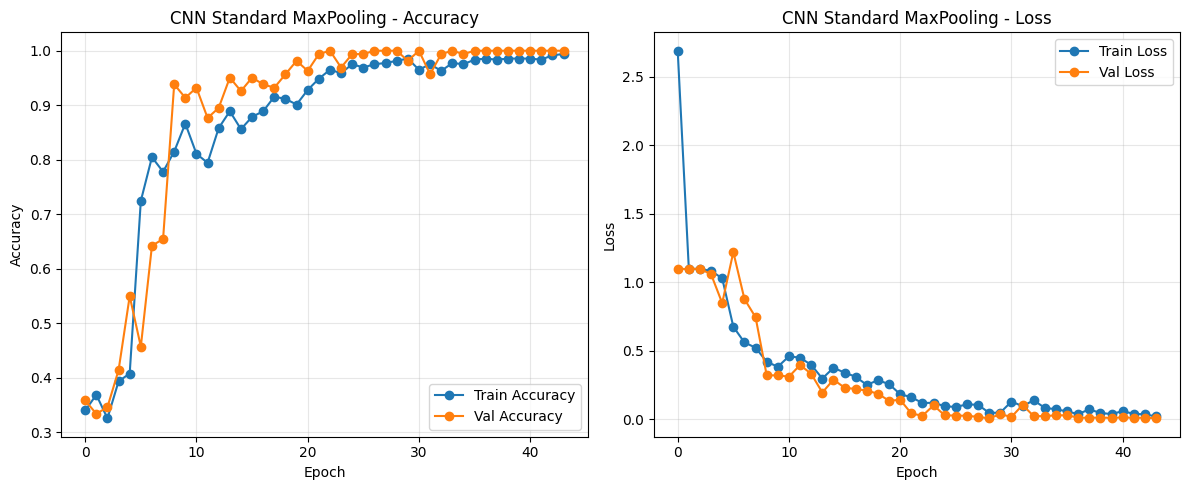


✓ Skenario 1 completed!


In [11]:
# Model CNN Standar Maxpooling
def cnn_standard_max(img_height=224, img_width=224, num_classes=3, name='CNN_Standard_Maxpooling'):
  model_1 = Sequential([
      layers.Input(shape=(img_height, img_width, 3)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.2),

      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.2),

      layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ],name=name)
  return model_1

  #  Build Model
model_1  = cnn_standard_max(img_height, img_width)
model_1.summary()

# Compile
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model_1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

# Train
print("\n🚀 Training CNN Standard...")
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_1,
    verbose=1
)

# Evaluate
y_pred_1 = np.argmax(model_1.predict(test_ds, verbose=0), axis=1)
y_test_1 = np.concatenate([y for x, y in test_ds], axis=0)
results_1 = evaluate_and_save(
    y_test_1,
    y_pred_1,
    "Skenario 1: CNN Standard Maxpooling"
)

# Print detailed results
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"Test Accuracy:  {results_1['accuracy']:.4f}")
print(f"Test Precision: {results_1['precision']:.4f}")
print(f"Test Recall:    {results_1['recall']:.4f}")
print(f"Test F1-Score:  {results_1['f1_score']:.4f}")
print("="*60)

# Check if model is actually learning
print("\n" + "="*60)
print("TRAINING DIAGNOSTICS")
print("="*60)

final_train_acc = history_1.history['accuracy'][-1]
final_val_acc = history_1.history['val_accuracy'][-1]
best_val_acc = max(history_1.history['val_accuracy'])

print(f"Final Train Accuracy: {final_train_acc:.4f}")
print(f"Final Val Accuracy:   {final_val_acc:.4f}")
print(f"Best Val Accuracy:    {best_val_acc:.4f}")
print(f"Train-Val Gap:        {abs(final_train_acc - final_val_acc):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_1, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(3))  # num_classes = 3
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - CNN Standard Maxpooling")
plt.show()

# Fungsi untuk menampilkan grafik akurasi & loss
def plot_training_history(history, title="Training History - Skenario 1"):
    plt.figure(figsize=(12,5))

    # Akurasi
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Panggil setelah training selesai
plot_training_history(history_1, title="CNN Standard MaxPooling")

print("="*60)
print("\n✓ Skenario 1 completed!")

# **Skenario 2 - Model CNN With Averagepooling**

Model: "CNN_Standard_Averagepooling"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 112, 112, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 56, 56, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 28, 28, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,387 (98.36 MB)

 Trainable params: 25,784,387 (98.36 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Training CNN Standard Averagepooling...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.3189 - loss: 2.4998
Epoch 1: val_accuracy improved from -inf to 0.48765, saving model to best_model_2.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 810ms/step - accuracy: 0.3185 - loss: 2.4620 - val_accuracy: 0.4877 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.3592 - loss: 1.0949
Epoch 2: val_accuracy did not improve from 0.48765
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - accuracy: 0.3599 - loss: 1.0949 - val_accuracy: 0.3580 - val_loss: 1.0894 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.4190 - loss: 1.0737
Epoch 3: val_accuracy improved from 0.48765 to 0.56173, saving model to best_model_2.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - accuracy: 0.4180 - loss: 1.0731 - val_accuracy: 0.5617 - val_loss: 0.9411 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.5074 - loss: 0.9406
Epoch 4: val_accuracy improved from 0.56173 to 0.67901, saving model to best_model_2.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 562ms/step - accuracy: 0.5098 - loss: 0.9388 - val_accuracy: 0.6790 - val_loss: 0.7555 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6936 - loss: 0.8204
Epoch 5: val_accuracy improved from 0.67901 to 0.93210, saving model to best_model_2.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 565ms/step - accuracy: 0.6927 - loss: 0.8201 - val_accuracy: 0.9321 - val_loss: 0.4600 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8377 - loss: 0.5489
Epoch 6: val_accuracy did not improve from 0.93210
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.8392 - loss: 0.5446 - val_accuracy: 0.9136 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9115 - loss: 0.2895
Epoch 7: val_accuracy did not improve from 0.93210
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.9120 - loss: 0.2884 - val_accuracy: 0.9321 - val_loss: 0.1254 - learning_rate: 0.0010
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9483 - loss: 0.1623
Epoch 8: val_accuracy improved from 0.93210 to 0.99383, saving model to best_model_2.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.9478 - loss: 0.1619 - val_accuracy: 0.9938 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9350 - loss: 0.2097
Epoch 9: val_accuracy did not improve from 0.99383
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 401ms/step - accuracy: 0.9352 - loss: 0.2091 - val_accuracy: 0.9938 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9709 - loss: 0.1384
Epoch 10: val_accuracy did not improve from 0.99383
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 505ms/step - accuracy: 0.9700 - loss: 0.1393 - val_accuracy: 0.9938 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9582 - loss: 0.1185
Epoch 11: val_accuracy did not improve from 0.99383
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - accuracy: 0.9579 - loss: 0.1199 - val_accuracy: 0.9691 - val_loss: 0.0703 - learning_rate: 0.0010
Epoch 12/50
16/16 ━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - accuracy: 0.9772 - loss: 0.0597 - val_accuracy: 1.0000 - val_loss: 0.0070 - learning_rate: 5.0000e-04
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9575 - loss: 0.1184
Epoch 16: val_accuracy did not improve from 1.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - accuracy: 0.9584 - loss: 0.1163 - val_accuracy: 0.9877 - val_loss: 0.0178 - learning_rate: 5.0000e-04
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9815 - loss: 0.0477
Epoch 17: val_accuracy did not improve from 1.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.9816 - loss: 0.0480 - val_accuracy: 0.9938 - val_loss: 0.0121 - learning_rate: 5.0000e-04
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9873 - loss: 0.0496
Epoch 18: val_accuracy did not improve from 1.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - accuracy: 0.9870 - loss: 0.0505 - val_accuracy: 0.9877 - val_loss: 0.0220 - learning_rate: 5.0000e-04
Epo

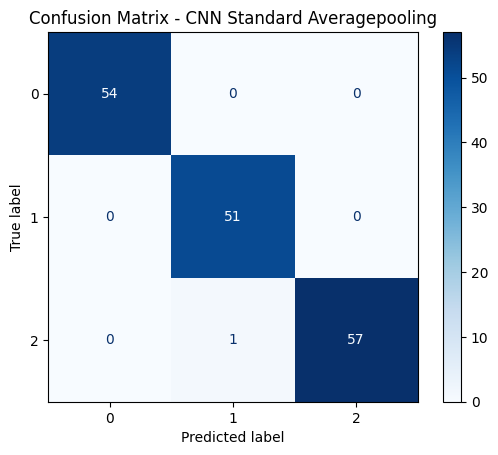

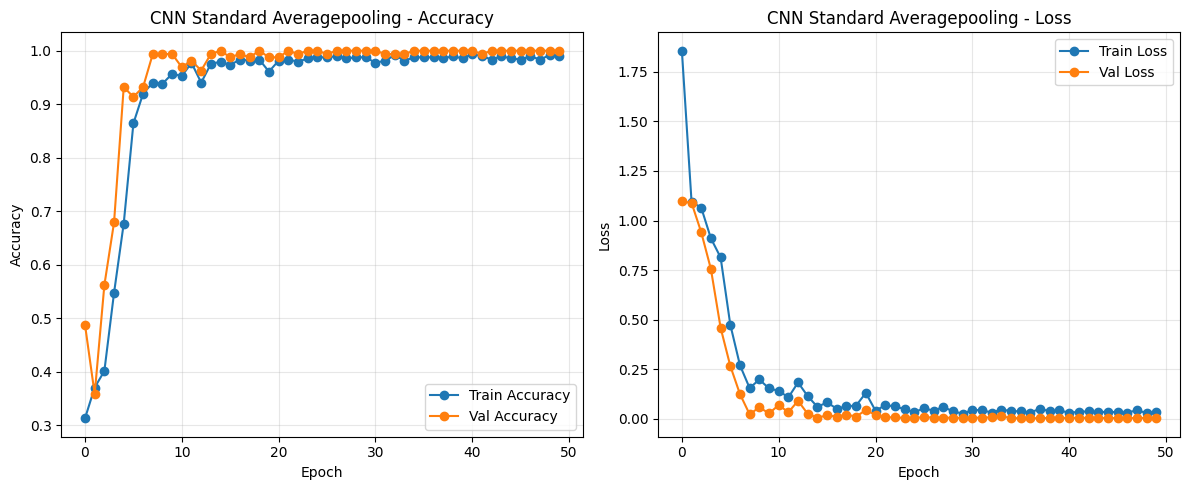


✓ Skenario 2 completed!


In [12]:
# Model CNN Standar Averagepooling
def cnn_standard_avg(img_height=224, img_width=224, num_classes=3, name='CNN_Standard_Averagepooling'):
  model_2 = Sequential([
      layers.Input(shape=(img_height, img_width, 3)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      layers.AveragePooling2D(2, 2),
      layers.Dropout(0.2),

      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.AveragePooling2D(2, 2),
      layers.Dropout(0.2),

      layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      layers.AveragePooling2D(2, 2),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ], name=name)
  return model_2

#  Build Model
model_2  = cnn_standard_avg(img_height, img_width)
model_2.summary()

# Compile
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_2 = [
    EarlyStopping(monitor='val_loss',patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6,verbose=1),
    ModelCheckpoint('best_model_2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

# Train
print("\n🚀 Training CNN Standard Averagepooling...")
history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_2,
    verbose=1
)

# Evaluasi
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

y_pred_2 = np.argmax(model_2.predict(test_ds, verbose=0), axis=1)
y_test_2 = np.concatenate([y for x, y in test_ds], axis=0)

results_2 = evaluate_and_save(
    y_test_2,
    y_pred_2,
    "Skenario 2: CNN Standard Averagepooling"
)

# Detail Hasil
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"Test Accuracy:  {results_2['accuracy']:.4f}")
print(f"Test Precision: {results_2['precision']:.4f}")
print(f"Test Recall:    {results_2['recall']:.4f}")
print(f"Test F1-Score:  {results_2['f1_score']:.4f}")
print("="*60)

# Cek proses belajar model
print("\n" + "="*60)
print("TRAINING DIAGNOSTICS")
print("="*60)

final_train_acc_2 = history_2.history['accuracy'][-1]
final_val_acc_2 = history_2.history['val_accuracy'][-1]
best_val_acc_2 = max(history_2.history['val_accuracy'])

print(f"Final Train Accuracy: {final_train_acc_2:.4f}")
print(f"Final Val Accuracy:   {final_val_acc_2:.4f}")
print(f"Best Val Accuracy:    {best_val_acc_2:.4f}")
print(f"Train-Val Gap:        {abs(final_train_acc_2 - final_val_acc_2):.4f}")
print("="*60)

# Confusion Matrix
cm = confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(3))  # num_classes = 3
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - CNN Standard Averagepooling")
plt.show()

# Fungsi untuk menampilkan grafik akurasi & loss
def plot_training_history(history, title="Training History - Skenario 2"):
    plt.figure(figsize=(12,5))

    # Akurasi
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Panggil setelah training selesai
plot_training_history(history_2, title="CNN Standard Averagepooling")

print("\n✓ Skenario 2 completed!")

# **Skenario 3 -  CNN dengan Hybrid Pooling**


🚀 Training model dengan alpha = 0.1...


📊 Alpha 0.1 → Test Accuracy = 0.9939

🚀 Training model dengan alpha = 0.3...


📊 Alpha 0.3 → Test Accuracy = 0.9877

🚀 Training model dengan alpha = 0.5...
📊 Alpha 0.5 → Test Accuracy = 0.9939

🚀 Training model dengan alpha = 0.7...
📊 Alpha 0.7 → Test Accuracy = 1.0000

🚀 Training model dengan alpha = 0.9...
📊 Alpha 0.9 → Test Accuracy = 0.9939

🏆 Alpha terbaik: 0.7 | Accuracy = 1.0000


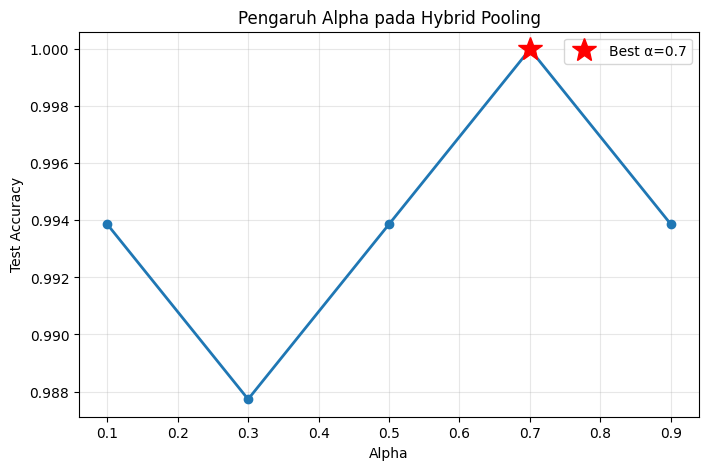


Skenario 3: CNN Hybrid Pooling (Alpha=0.7)
  Accuracy: 1.0000 | F1: 1.0000

RESULTS SUMMARY for Skenario 3 (Best Alpha=0.7)
Test Accuracy:  1.0000
Test Precision: 1.0000
Test Recall:    1.0000
Test F1-Score:  1.0000


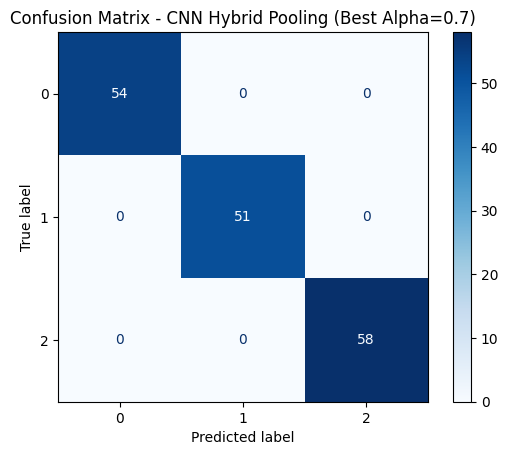

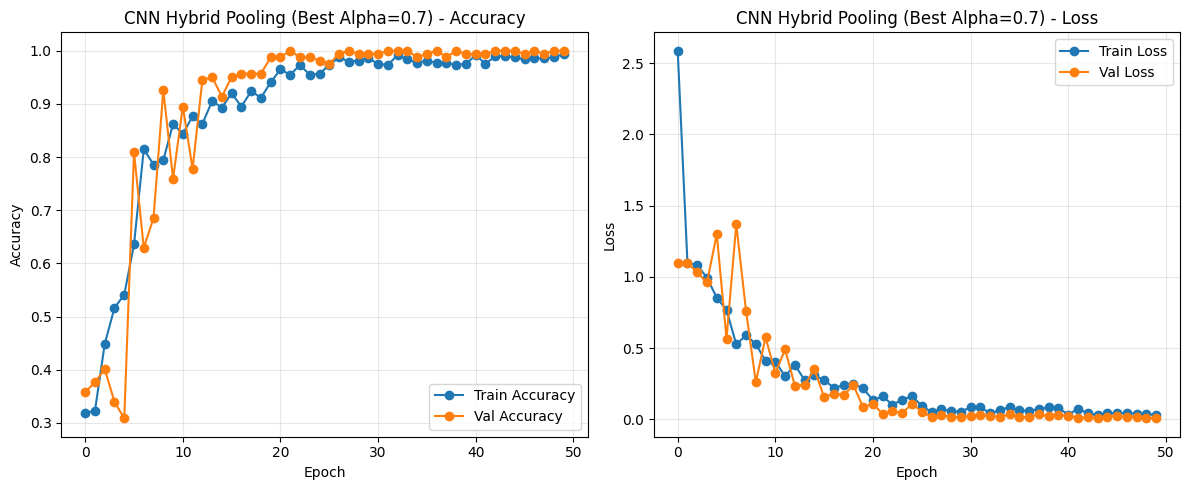


✓ Skenario 3 completed!


In [13]:
# Model CNN dengan Hybrid Pooling
def cnn_hybrid_pooling(img_height=224, img_width=224, alpha=0.5, num_classes=3, name='CNN Hybrid Pooling'):
  model_3 = Sequential([
      layers.Input(shape=(224, 224, 3)),
      layers.Conv2D(32, 3, activation='relu', padding='same'),
      HybridPooling(pool_size=(2, 2), alpha=alpha),
      layers.Dropout(0.2),

      layers.Conv2D(64, 3, activation='relu', padding='same'),
      HybridPooling(pool_size=(2, 2), alpha=alpha),
      layers.Dropout(0.2),

      layers.Conv2D(128, 3, activation='relu', padding='same'),
      HybridPooling(pool_size=(2, 2), alpha=alpha),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ])
  return model_3

def train_eval(alpha, train_ds, val_ds, epochs=50, test_ds=None):
    print(f"\n🚀 Training model dengan alpha = {alpha}...")
    # Buat model
    model_3 = cnn_hybrid_pooling(alpha=alpha)
    # Compile model
    model_3.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    # Setup callbacks (auto stop kalau tidak membaik)
    callbacks_3 = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # Training
    history_3 = model_3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks_3,
        verbose=0  # Tampilkan progress
    )

    y_pred_3 = np.argmax(model_3.predict(test_ds, verbose=0), axis=1)
    y_true_3 = np.concatenate([y for _, y in test_ds], axis=0)
    acc_3 = accuracy_score(y_true_3, y_pred_3)

    return acc_3, model_3, history_3, y_pred_3, y_true_3


def find_best_alpha(train_ds, val_ds, test_ds, alpha_list=None):
    results = []

    for alpha in alpha_list:
        acc_3, model_3, history_3, y_pred_3, y_true_3 = train_eval(
            alpha, train_ds, val_ds, test_ds=test_ds
        )
        results.append({'alpha': alpha, 'accuracy': acc_3, 'model': model_3, 'history': history_3, 'y_pred': y_pred_3, 'y_true': y_true_3})
        print(f"📊 Alpha {alpha} → Test Accuracy = {acc_3:.4f}")

    best = max(results, key=lambda x: x['accuracy'])
    print(f"\n🏆 Alpha terbaik: {best['alpha']} | Accuracy = {best['accuracy']:.4f}")
    return results, best


def plot_alpha_results(results):
    alphas = [r['alpha'] for r in results]
    accs = [r['accuracy'] for r in results]

    best_idx = np.argmax(accs)

    plt.figure(figsize=(8, 5))
    plt.plot(alphas, accs, 'o-', linewidth=2)
    plt.plot(alphas[best_idx], accs[best_idx], 'r*', markersize=18,
             label=f"Best α={alphas[best_idx]}")

    plt.xlabel("Alpha")
    plt.ylabel("Test Accuracy")
    plt.title("Pengaruh Alpha pada Hybrid Pooling")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Moved ALPHA_LIST to global scope
ALPHA_LIST = [0.1, 0.3, 0.5, 0.7, 0.9]

results_3, best_3 = find_best_alpha(
    train_ds,
    val_ds,
    test_ds,
    ALPHA_LIST
)

plot_alpha_results(results_3)

# Evaluasi dan simpan best model dari Skenario 3
best_alpha_model = best_3['model']
y_pred_3_best = best_3['y_pred']
y_true_3_best = best_3['y_true']

results_3_final = evaluate_and_save(
    y_true_3_best,
    y_pred_3_best,
    f"Skenario 3: CNN Hybrid Pooling (Alpha={best_3['alpha']})"
)

# Detail Hasil Skenario 3
print("\n" + "="*60)
print(f"RESULTS SUMMARY for Skenario 3 (Best Alpha={best_3['alpha']})")
print("="*60)
print(f"Test Accuracy:  {results_3_final['accuracy']:.4f}")
print(f"Test Precision: {results_3_final['precision']:.4f}")
print(f"Test Recall:    {results_3_final['recall']:.4f}")
print(f"Test F1-Score:  {results_3_final['f1_score']:.4f}")
print("="*60)

# Confusion Matrix untuk best Skenario 3
cm = confusion_matrix(y_true_3_best, y_pred_3_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes)) # Use num_classes for display labels
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix - CNN Hybrid Pooling (Best Alpha={best_3['alpha']})")
plt.show()

# Plot training history untuk best Skenario 3
plot_training_history(best_3['history'], title=f"CNN Hybrid Pooling (Best Alpha={best_3['alpha']})")

print("\n✓ Skenario 3 completed!")

# **Skenario 4 - CNN Standar + KNN**

In [ ]:
# Model CNN Standard + KNN
def cnn_standard(img_height=224, img_width=224, n_classes=3):
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    # Layer 1
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D(2, 2)(x)
    # Layer 2
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    # Layer 3
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    # Layer Ekstraksi Fitur
    x = layers.Flatten()(x)
    features = layers.Dense(512, activation='relu', name='feature_dense')(x)
    x = layers.Dropout(0.5)(features)
    # Layer Output
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs, name='CNN_Standard_3')
    return model

# Membuat model
model_3 = build_cnn_standard_functional(img_height, img_width, n_classes)
model_3.summary()

# Compile model CNN
model_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat Callbacks
callbacks_3 = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_3.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Train model dengan augmentasi
start_time = time.time()

history_3 = model_3.fit(
    train_ds, # train dengan data augmentasi
    validation_data=val_ds, # validasi tanpa augmentasi
    epochs=50,
    callbacks=callbacks_3,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f} seconds")
print(f"  Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final val accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Visualisasi training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title('Model Accuracy', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title('Model Loss', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Membuat Ekstraksi Fitur
feature_extractor = Model(
    inputs=model_cnn.input,  # ← Langsung dari model.input
    outputs=model_cnn.get_layer('features').output,  # ← Output Dense(512)
    name='Feature_Extractor'
)

print(f"✓ Feature extractor created")
print(f"  Input shape: {feature_extractor.input_shape}")
print(f"  Output shape: {feature_extractor.output_shape}")

# Ekstraksi fitur tanpa augmentasi (menggunakan dataset tanpa augmentasi untuk konsistensi)
train_ds_no_aug = val_test_dataset(X_train, y_train)
val_ds_no_aug = val_test_dataset(X_val, y_val)
test_ds_no_aug = val_test_dataset(X_test, y_test)

# Extract features
print("  Extracting train features...")
train_features = feature_extractor.predict(train_ds_no_aug, verbose=0)

print("  Extracting val features...")
val_features = feature_extractor.predict(val_ds_no_aug, verbose=0)

print("  Extracting test features...")
test_features = feature_extractor.predict(test_ds_no_aug, verbose=0)

print(f"\n✓ Features extracted")
print(f"  Train features shape: {train_features.shape}")
print(f"  Val features shape: {val_features.shape}")
print(f"  Test features shape: {test_features.shape}")

# Proses scalling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features_3)
val_scaled = scaler.transform(val_features_3)
test_scaled = scaler.transform(test_features_3)

# Proses PCA
pca = PCA(n_components=100, random_state=42)  # Tingkatkan ke 100
train_pca = pca.fit_transform(train_scaled)
val_pca = pca.transform(val_scaled)
test_pca = pca.transform(test_scaled)

print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# STEP 5: GRIDSEARCH KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(train_pca, y_train)

print(f"Best params: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.4f}")

# STEP 6: EVALUATE
y_pred = grid.predict(test_pca)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Evaluate and save results for Skenario 3
results_3 = evaluate_and_save(y_test, y_pred, "Skenario 3: CNN Standard + KNN")

# **Skenario 5 - CNN Hybrid + KNN**

In [ ]:

# Build CNN Hybrid model using Sequential API
def build_cnn_hybrid_functional(img_height=224, img_width=224, prob_weight=0.8):
  model = Sequential([
    tf.keras.Input(shape=(img_height, img_width, 3)), # Explicitly define input layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Gunakan Hybrid Pooling instead of Flatten
    hybrid_pooling(prob_weight=prob_weight),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
    ], name=f'CNN_Hybrid_PW{prob_weight}')

  return model

# Create the full CNN model and its input tensor
PROB_WEIGHT_S4 = 0.8 # Define a specific prob_weight for Skenario 4
model_4 = build_cnn_hybrid_functional(img_height, img_width, PROB_WEIGHT_S4)

# Compile and Train the full CNN model (model_4)
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_4.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)
model_4.summary()

# Mengambil layer ekstraksi fitur (output dari Dense(512) sebelum Dropout)
# Create a new Sequential model that goes up to the desired feature extraction layer
ekstraksi_fitur_s4 = Sequential(model_4.layers[:-2], name='feature_extractor_s4')

# Ekstraksi fitur tanpa augmentasi (menggunakan dataset tanpa augmentasi untuk konsistensi)
# train_ds_no_aug, val_ds_no_aug, test_ds_no_aug are already defined globally

train_features_s4 = ekstraksi_fitur_s4.predict(train_ds_no_aug)
val_features_s4 = ekstraksi_fitur_s4.predict(val_ds_no_aug)
test_features_s4 = ekstraksi_fitur_s4.predict(test_ds_no_aug)

# Proses scalling
scaler_s4 = StandardScaler()
train_scaled_s4 = scaler_s4.fit_transform(train_features_s4)
val_scaled_s4 = scaler_s4.transform(val_features_s4)
test_scaled_s4 = scaler_s4.transform(test_features_s4)

# Proses PCA
pca_s4 = PCA(n_components=100, random_state=42)  # Tingkatkan ke 100
train_pca_s4 = pca_s4.fit_transform(train_scaled_s4)
val_pca_s4 = pca_s4.transform(val_scaled_s4)
test_pca_s4 = pca_s4.transform(test_scaled_s4)

print(f"Variance explained: {pca_s4.explained_variance_ratio_.sum():.4f}")

# STEP 5: GRIDSEARCH KNN
param_grid_s4 = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_s4 = GridSearchCV(KNeighborsClassifier(), param_grid_s4, cv=5, scoring='accuracy', n_jobs=-1)
grid_s4.fit(train_pca_s4, y_train)

print(f"Best params: {grid_s4.best_params_}")
print(f"Best CV score: {grid_s4.best_score_:.4f}")

# STEP 6: EVALUATE
y_pred_s4 = grid_s4.predict(test_pca_s4)
test_acc_s4 = accuracy_score(y_test, y_pred_s4)
print(f"Test Accuracy: {test_acc_s4:.4f}")

# Evaluate and save results for Skenario 4
results_s4 = evaluate_and_save(y_test, y_pred_s4, f"Skenario 4: CNN Hybrid (PW={PROB_WEIGHT_S4}) + KNN")


# **Skenario 5 - Just KNN**

In [ ]:
def extract_handcrafted_features(images):
    """
    Ekstrak fitur sederhana dari gambar:
    - Mean, std, min, max untuk setiap channel RGB
    - Histogram features
    """
    features = []

    for img in images:
        feat = []

        # RGB statistics
        for channel in range(3):
            channel_data = img[:, :, channel].flatten()
            feat.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.min(channel_data),
                np.max(channel_data),
                np.median(channel_data)
            ])

        # Histogram features (10 bins per channel)
        for channel in range(3):
            hist, _ = np.histogram(img[:, :, channel], bins=10, range=(0.0, 1.0)) # Ensure range matches normalized images
            # Handle case where sum of hist is zero to avoid NaN
            if np.sum(hist) == 0:
                feat.extend(np.zeros_like(hist)) # All zeros if no pixels in range
            else:
                feat.extend(hist / np.sum(hist))  # Normalize

        features.append(feat)

    return np.array(features)

# Helper function to extract preprocessed images from a tf.data.Dataset
def get_images_from_dataset(dataset):
    images = []
    # dataset yields (image, label) tuples, which are already preprocessed and scaled
    for img_batch, _ in dataset.as_numpy_iterator():
        images.extend(img_batch)
    return np.array(images)

print("\n[1/3] Extracting handcrafted features...")

# Extract preprocessed images from the datasets
preprocessed_train_images = get_images_from_dataset(train_ds)
preprocessed_val_images = get_images_from_dataset(val_ds)
preprocessed_test_images = get_images_from_dataset(test_ds)

train_features_s5 = extract_handcrafted_features(preprocessed_train_images)
val_features_s5 = extract_handcrafted_features(preprocessed_val_images)
test_features_s5 = extract_handcrafted_features(preprocessed_test_images)

print(f"  Train features: {train_features_s5.shape}")
print(f"  Val features: {val_features_s5.shape}")
print(f"  Test features: {test_features_s5.shape}")

print("\n[2/3] Scaling features...")
scaler_s5 = StandardScaler()
train_scaled_s5 = scaler_s5.fit_transform(train_features_s5)
val_scaled_s5 = scaler_s5.transform(val_features_s5)
test_scaled_s5 = scaler_s5.transform(test_features_s5)

print("\n[3/3] Training KNN with GridSearch...")
param_grid_s5 = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_s5 = KNeighborsClassifier()
grid_s5 = GridSearchCV(knn_s5, param_grid_s5, cv=5, scoring='accuracy',
                       n_jobs=-1, verbose=1)
grid_s5.fit(train_scaled_s5, y_train)

print(f"\n  Best parameters: {grid_s5.best_params_}")
print(f"  Best CV score: {grid_s5.best_score_:.4f}")

# Evaluate
y_pred_s5 = grid_s5.predict(test_scaled_s5)
results_s5 = evaluate_and_save(y_test, y_pred_s5, # Changed evaluate_model to evaluate_and_save
                           "Skenario 5: KNN Only (Handcrafted Features)")

# Plot
# plot_confusion_matrix(results_s5['confusion_matrix'], class_names,
#                      "Skenario 5: KNN Only",
#                      "s5_confusion_matrix.png")

print("\n✓ Skenario 5 completed!")

# **Komparasi Semua Skenario Uji**

In [ ]:
print("\n" + "="*80)
print("COMPARISON OF ALL 5 SCENARIOS")
print("="*80)

# Compile results
comparison_data = {
    'Scenario': [
        'S1: CNN Standard',
        'S2: CNN + Hybrid Pooling',
        'S3: CNN Standard + KNN',
        'S4: CNN Hybrid + KNN',
        'S5: KNN Only'
    ],
    'Accuracy': [
        results_1['accuracy'],
        results_2['accuracy'],
        results_3['accuracy'],
        results_s4['accuracy'],
        results_s5['accuracy']
    ],
    'Precision': [
        results_1['precision'],
        results_2['precision'],
        results_3['precision'],
        results_s4['precision'],
        results_s5['precision']
    ],
    'Recall': [
        results_1['recall'],
        results_2['recall'],
        results_3['recall'],
        results_s4['recall'],
        results_s5['recall']
    ],
    'F1-Score': [
        results_1['f1_score'],
        results_2['f1_score'],
        results_3['f1_score'],
        results_s4['f1_score'],
        results_s5['f1_score']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("RESULTS TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best scenario
best_idx = comparison_df['Accuracy'].idxmax()
best_scenario = comparison_df.iloc[best_idx]

print(f"\n🏆 BEST SCENARIO: {best_scenario['Scenario']}")
print(f"   Accuracy: {best_scenario['Accuracy']:.4f}")
print(f"   F1-Score: {best_scenario['F1-Score']:.4f}")

# Save Hasil
comparison_df.to_csv('scenario_comparison_results.csv', index=False)
print("\n✓ Results saved to 'scenario_comparison_results.csv'")